First, we will extract features using the VGG16 and VGG 19. While extracting, these networks will have the weights that are pre-trained on 'ImageNet'. 
After extracting the features, we will pass the resulting tensor through a flattening layer and then some dense layers and ultimately classify using Softmax. 

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.applications import VGG16, VGG19

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
cd gdrive/MyDrive/cpe_695

/content/gdrive/MyDrive/cpe_695


In [4]:
ls

 Feature_extraction.ipynb         transfer_learning.ipynb
'Load in data and labels.ipynb'   transfer_learning_newdata.ipynb
 network_performance.ipynb        Untitled0.ipynb
'Notes Tasks Meetings:.gdoc'      X.pickle
 original_images/                 xrays/
 prelim_results.ipynb             y.pickle


First, we are going to read in the data. 

In [5]:
TRAINDIR = "xrays/train"
VALDIR = "xrays/val"
TESTDIR = "xrays/test"

In [6]:
IMG_W, IMG_H = 224, 224

In [7]:
import os, shutil
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size=12

In [8]:
def extract_features(directory, sample_count, network):
  features = np.zeros(shape=(sample_count, 7, 7, 512))
  labels = np.zeros(shape=(sample_count, 3))

  #Preprocess data
  generator = datagen.flow_from_directory(directory, target_size=(IMG_W, IMG_H),
                                          batch_size=batch_size,
                                          class_mode='categorical')
  
  #Pass data through convolution base
  i = 0
  for inputs_batch, labels_batch in generator:
    features_batch = network.predict(inputs_batch)
    features[i * batch_size: (i+1) * batch_size] = features_batch
    labels[i * batch_size: (i+1) * batch_size] = labels_batch
    i += 1
    if i*batch_size >= sample_count:
      break
  return features, labels


In [31]:
train_generator = datagen.flow_from_directory(TRAINDIR, target_size=(IMG_W, IMG_H),
                                          batch_size=batch_size,
                                          class_mode='categorical')

Found 760 images belonging to 3 classes.


In [32]:
train_generator.class_indices.keys()

dict_keys(['No_findings', 'Pneumonia', 'covid19'])

In [34]:
val_generator = datagen.flow_from_directory(VALDIR, target_size=(IMG_W, IMG_H),
                                          batch_size=batch_size,
                                          class_mode='categorical')

Found 95 images belonging to 3 classes.


In [35]:
val_generator.class_indices.keys()

dict_keys(['No_findings', 'Pneumonia', 'covid19'])

In [9]:
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_W, IMG_H, 3))
vgg19_base = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_W, IMG_H, 3))


80142336/80134624 [==============================] - 2s 0us/step


In [10]:
#Freeze the base models
vgg16_base.trainable = False
vgg19_base.trainable = False

# Feature Extraction and Transfer Learning with VGG 16

In [11]:
train_features_16, train_labels_16 = extract_features(TRAINDIR, 760, vgg16_base)
val_features_16, val_labels_16 = extract_features(VALDIR, 95, vgg16_base)
test_features_16, test_labels_16 = extract_features(TESTDIR, 95, vgg16_base)

Found 760 images belonging to 3 classes.
Found 95 images belonging to 3 classes.
Found 95 images belonging to 3 classes.


In [12]:
train_features_16.shape

(760, 7, 7, 512)

In [13]:
train_labels_16.shape

(760, 3)

We need to flatten our feature matrix by passing it through a flattening layer. After that two more fully connected layers with 4096 neurons each has been added and then one with 1000 and finally with 3. The last three fully connected layers have been added as per the full VGG 16 architecture. 
The final layer has 3 as dimension as there are 3 categories that we wish to classify among. 

In [14]:
from tensorflow.keras import layers, models

model = models.Sequential()
model.add(layers.Flatten())
model.add(layers.Dense(4096))
model.add(layers.Dense(4096))
model.add(layers.Dense(1000))
model.add(layers.Dense(3, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

hist = model.fit(train_features_16, train_labels_16, batch_size=50, epochs=30, validation_data=(val_features_16, val_labels_16))

Epoch 1/30
16/16 [==============================] - 13s 812ms/step - loss: 281.1388 - accuracy: 0.4026 - val_loss: 94.7183 - val_accuracy: 0.3684
Epoch 2/30
16/16 [==============================] - 13s 804ms/step - loss: 59.3834 - accuracy: 0.5316 - val_loss: 10.4061 - val_accuracy: 0.6632
Epoch 3/30
16/16 [==============================] - 13s 807ms/step - loss: 17.7999 - accuracy: 0.6961 - val_loss: 11.5109 - val_accuracy: 0.7263
Epoch 4/30
16/16 [==============================] - 13s 808ms/step - loss: 11.0489 - accuracy: 0.7947 - val_loss: 7.1531 - val_accuracy: 0.7789
Epoch 5/30
16/16 [==============================] - 13s 807ms/step - loss: 3.6355 - accuracy: 0.8434 - val_loss: 4.7821 - val_accuracy: 0.7579
Epoch 6/30
16/16 [==============================] - 13s 804ms/step - loss: 0.9546 - accuracy: 0.9013 - val_loss: 0.9338 - val_accuracy: 0.8211
Epoch 7/30
16/16 [==============================] - 13s 812ms/step - loss: 0.4367 - accuracy: 0.8882 - val_loss: 1.4959 - val_accuracy

In [15]:
type(hist)

tensorflow.python.keras.callbacks.History

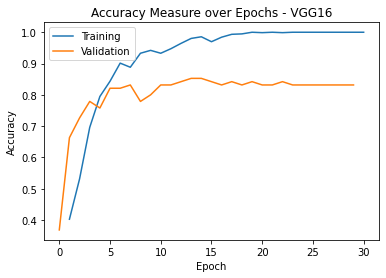

In [16]:
import matplotlib.pyplot as plt

epochs = [i for i in range(1,31)]

plt.plot(epochs, hist.history['accuracy'], hist.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Accuracy Measure over Epochs - VGG16')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

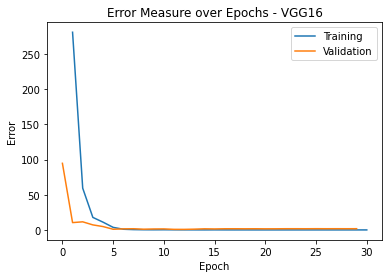

In [17]:
plt.plot(epochs, hist.history['loss'], hist.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Error Measure over Epochs - VGG16')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()

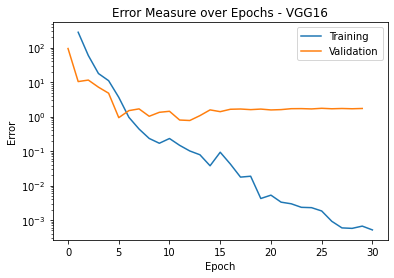

In [18]:
plt.plot(epochs, hist.history['loss'], hist.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Error Measure over Epochs - VGG16')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.yscale('log')
plt.show()

In [19]:
model.evaluate(train_features_16, train_labels_16)

24/24 [==============================] - 4s 162ms/step - loss: 3.9762e-04 - accuracy: 1.0000


[0.0003976198495365679, 1.0]

In [20]:
model.evaluate(val_features_16, val_labels_16)

3/3 [==============================] - 0s 124ms/step - loss: 1.7246 - accuracy: 0.8316


[1.7246395349502563, 0.8315789699554443]

In [21]:
model.evaluate(test_features_16, test_labels_16)

3/3 [==============================] - 0s 122ms/step - loss: 88.5284 - accuracy: 0.0316


[88.52838134765625, 0.031578946858644485]

In [24]:
pred_train_labels_16 = model.predict(train_features_16)

In [25]:
pred_train_labels_16.shape

(760, 3)

In [ ]:
y_pred_train_16 = np.argmax()

Accuracy on Train Set:  1.0


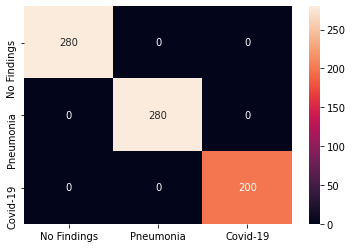

In [33]:
#get values predicted by model for training set
pred_train_labels_16 = model.predict(train_features_16)

#convert softmax output probabilities into single vector containing classes for each instance
#need this for sklearn metrics
y_train_16 = np.argmax(train_labels_16, axis=1)
y_pred_train_16 = np.argmax(pred_train_labels_16, axis=1)

from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns

print('Accuracy on Train Set: ', metrics.accuracy_score(y_train_16, y_pred_train_16))
categories = ['No Findings', 'Pneumonia', 'Covid-19']
cm_train_16 = confusion_matrix(y_train_16, y_pred_train_16)
sns.heatmap(cm_train_16, xticklabels=categories, yticklabels=categories, annot=True, fmt='d')


Accuracy on Val Set:  0.8315789473684211


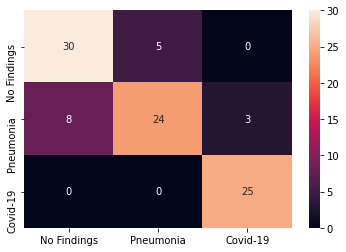

In [36]:
#confusion matrix for validation data
pred_val_labels_16 = model.predict(val_features_16)

y_val_16 = np.argmax(val_labels_16, axis=1)
y_pred_val_16 = np.argmax(pred_val_labels_16, axis=1)

print('Accuracy on Val Set: ', metrics.accuracy_score(y_val_16, y_pred_val_16))

cm_val_16 = confusion_matrix(y_val_16, y_pred_val_16)
sns.heatmap(cm_val_16, xticklabels=categories, yticklabels=categories, annot=True, fmt='d')


Accuracy on Test Set:  0.031578947368421054


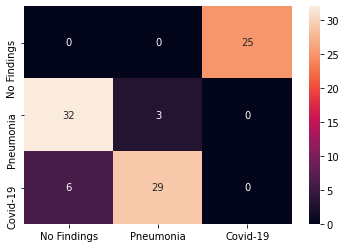

In [37]:
#confusion matrix for test data
pred_test_labels_16 = model.predict(test_features_16)

y_test_16 = np.argmax(test_labels_16, axis=1)
y_pred_test_16 = np.argmax(pred_test_labels_16, axis=1)

print('Accuracy on Test Set: ', metrics.accuracy_score(y_test_16, y_pred_test_16))

cm_test_16 = confusion_matrix(y_test_16, y_pred_test_16)
sns.heatmap(cm_test_16, xticklabels=categories, yticklabels=categories, annot=True, fmt='d')


# VGG19

In [38]:
train_features_19, train_labels_19 = extract_features(TRAINDIR, 760, vgg19_base)
val_features_19, val_labels_19 = extract_features(VALDIR, 95, vgg19_base)
test_features_19, test_labels_19 = extract_features(TESTDIR, 95, vgg19_base)

Found 760 images belonging to 3 classes.
Found 95 images belonging to 3 classes.
Found 95 images belonging to 3 classes.


In [40]:
model2 = models.Sequential()
model2.add(layers.Flatten())
model2.add(layers.Dense(4096))
model2.add(layers.Dense(4096))
model2.add(layers.Dense(1000))
model2.add(layers.Dense(3, activation="softmax"))
model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

hist2 = model2.fit(train_features_19, train_labels_19, batch_size=50, epochs=30, validation_data=(val_features_19, val_labels_19))

Epoch 1/30
16/16 [==============================] - 13s 830ms/step - loss: 635.8836 - accuracy: 0.3566 - val_loss: 147.8297 - val_accuracy: 0.3684
Epoch 2/30
16/16 [==============================] - 13s 814ms/step - loss: 58.9251 - accuracy: 0.3895 - val_loss: 87.1763 - val_accuracy: 0.4105
Epoch 3/30
16/16 [==============================] - 13s 818ms/step - loss: 36.0688 - accuracy: 0.5921 - val_loss: 18.8036 - val_accuracy: 0.4737
Epoch 4/30
16/16 [==============================] - 13s 818ms/step - loss: 7.1628 - accuracy: 0.6329 - val_loss: 3.2667 - val_accuracy: 0.7263
Epoch 5/30
16/16 [==============================] - 13s 820ms/step - loss: 2.1469 - accuracy: 0.7526 - val_loss: 1.1155 - val_accuracy: 0.7895
Epoch 6/30
16/16 [==============================] - 13s 819ms/step - loss: 0.7397 - accuracy: 0.8618 - val_loss: 1.0210 - val_accuracy: 0.8211
Epoch 7/30
16/16 [==============================] - 13s 813ms/step - loss: 0.4400 - accuracy: 0.8816 - val_loss: 0.6458 - val_accuracy

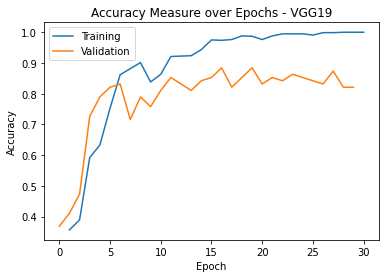

In [41]:
epochs2 = [i for i in range(1,31)]
plt.plot(epochs2, hist2.history['accuracy'], hist2.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Accuracy Measure over Epochs - VGG19')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

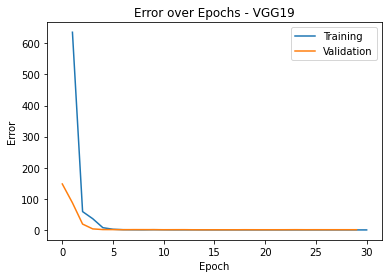

In [42]:
plt.plot(epochs2, hist2.history['loss'], hist2.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Error over Epochs - VGG19')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()

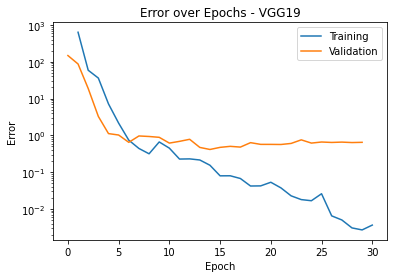

In [43]:
plt.plot(epochs2, hist2.history['loss'], hist2.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Error over Epochs - VGG19')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.yscale('log')
plt.show()

In [44]:
model2.evaluate(train_features_19, train_labels_19)

24/24 [==============================] - 4s 171ms/step - loss: 0.0021 - accuracy: 1.0000


[0.00213078991509974, 1.0]

In [45]:
model2.evaluate(val_features_19, val_labels_19)

3/3 [==============================] - 0s 131ms/step - loss: 0.6461 - accuracy: 0.8211


[0.6461466550827026, 0.821052610874176]

In [46]:
model2.evaluate(test_features_19, test_labels_19)

3/3 [==============================] - 0s 135ms/step - loss: 26.6873 - accuracy: 0.0526


[26.68730926513672, 0.05263157933950424]

Accuracy on Train Set:  1.0


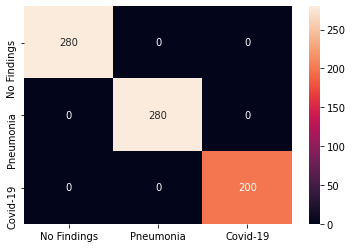

In [47]:
#confusion matrix for training data
pred_train_labels_19 = model2.predict(train_features_19)

y_train_19 = np.argmax(train_labels_19, axis=1)
y_pred_train_19 = np.argmax(pred_train_labels_19, axis=1)

print('Accuracy on Train Set: ', metrics.accuracy_score(y_train_19, y_pred_train_19))

cm_train_19 = confusion_matrix(y_train_19, y_pred_train_19)
sns.heatmap(cm_train_19, xticklabels=categories, yticklabels=categories, annot=True, fmt='d')


Accuracy on Val Set:  0.8210526315789474


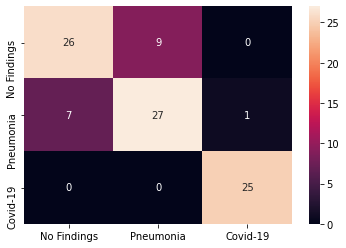

In [48]:
#confusion matrix for validation data
pred_val_labels_19 = model2.predict(val_features_19)

y_val_19 = np.argmax(val_labels_19, axis=1)
y_pred_val_19 = np.argmax(pred_val_labels_19, axis=1)

print('Accuracy on Val Set: ', metrics.accuracy_score(y_val_19, y_pred_val_19))

cm_val_19 = confusion_matrix(y_val_19, y_pred_val_19)
sns.heatmap(cm_val_19, xticklabels=categories, yticklabels=categories, annot=True, fmt='d')

Accuracy on Test Set:  0.05263157894736842


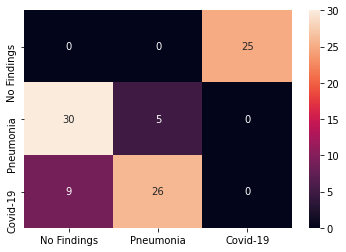

In [49]:
#confusion matrix for test data
pred_test_labels_19 = model2.predict(test_features_19)

y_test_19 = np.argmax(test_labels_19, axis=1)
y_pred_test_19 = np.argmax(pred_test_labels_19, axis=1)

print('Accuracy on Test Set: ', metrics.accuracy_score(y_test_19, y_pred_test_19))

cm_test_19 = confusion_matrix(y_test_19, y_pred_test_19)
sns.heatmap(cm_test_19, xticklabels=categories, yticklabels=categories, annot=True, fmt='d')

In [36]:
#switch the validation and test sets
model3 = models.Sequential()
model3.add(layers.Flatten())
model3.add(layers.Dense(4096))
model3.add(layers.Dense(4096))
model3.add(layers.Dense(1000))
model3.add(layers.Dense(3, activation="softmax"))
model3.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
hist3 = model3.fit(train_features_19, train_labels_19, batch_size=50, epochs=50, validation_data=(test_features_19, test_labels_19))

Epoch 1/50
16/16 [==============================] - 14s 886ms/step - loss: 519.3329 - accuracy: 0.3447 - val_loss: 372.9183 - val_accuracy: 0.3684
Epoch 2/50
16/16 [==============================] - 14s 879ms/step - loss: 96.9317 - accuracy: 0.4211 - val_loss: 106.7725 - val_accuracy: 0.0421
Epoch 3/50
16/16 [==============================] - 15s 913ms/step - loss: 20.4572 - accuracy: 0.6474 - val_loss: 116.9426 - val_accuracy: 0.0211
Epoch 4/50
16/16 [==============================] - 14s 878ms/step - loss: 6.9766 - accuracy: 0.7421 - val_loss: 98.5094 - val_accuracy: 0.0947
Epoch 5/50
16/16 [==============================] - 14s 882ms/step - loss: 4.6822 - accuracy: 0.7868 - val_loss: 69.8040 - val_accuracy: 0.0947
Epoch 6/50
16/16 [==============================] - 14s 877ms/step - loss: 2.0194 - accuracy: 0.8158 - val_loss: 59.7088 - val_accuracy: 0.0421
Epoch 7/50
16/16 [==============================] - 14s 875ms/step - loss: 0.8262 - accuracy: 0.8553 - val_loss: 48.5869 - val_ac